In [1]:
import sys
sys.path.insert(0,'../sensingbee')
from v0 import *

In [2]:
STREET_SHAPE_FOLDER = '/home/adelsondias/Downloads/newcastle_streets/'
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_30days/'

### Sensor's features ingestion

In [4]:
variables =  {
        'sensors':['NO2','Temperature','O3','CO'],
        'exogenous':['primary','trunk','motorway','construction','residential','traffic_signals','crossing','bus_stop','day','dow','hour']
}
metadata, osmf, sensors = load_data(LSOA_SHAPE_FOLDER, DATA_FOLDER)
sensors, metadata = resampling_sensors(sensors, metadata, variables, 'D')

MemoryError: 

In [5]:
# sensors feature ingestion
zx, zi = load_data__(DATA_FOLDER)
zx, zi = resampling_sensors__(zx, zi, 'D')

### Model training

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler


zxs = MinMaxScaler().fit_transform(zx)
# gb = GradientBoostingRegressor(n_estimators=2000, max_depth=5, max_features=None).fit(zxs,np.log(zi['Value']))
# save_model(gb, DATA_FOLDER+'gb_i0_2000-5.pkl')
gb = load_model(DATA_FOLDER+'gb_i0_2000-5.pkl')

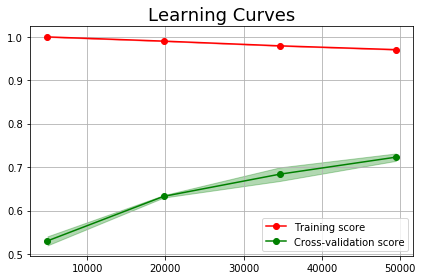

In [11]:
# plot_learning_curves(gb,zxs,np.log(zi['Value']))
train_sizes, train_scores, test_scores = learning_curve(
                                            gb, zxs,np.log(zi['Value']), scoring='r2', n_jobs=2,
                                            cv=ShuffleSplit(n_splits=3, test_size=0.1, random_state=0),
                                            train_sizes=np.linspace(.1, 1.0, 4))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.3,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.title('Learning Curves', fontsize=18)
#plt.xlabel('n_estimators={} max_depth={}'.format(200,5))
plt.tight_layout()
plt.show()

### Mesh features ingestion

In [7]:
mesh = load_mesh_csv(DATA_FOLDER+'mesh_valid-regions.csv')
osm_features = pd.read_csv(DATA_FOLDER+'50x50_v0_osm-features.csv',index_col=0)

# Finally... predict!

In [8]:
# to plot shape (optional)
lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}
newcastle = gpd.GeoSeries(shapely.ops.cascaded_union(lsoa['geometry']))

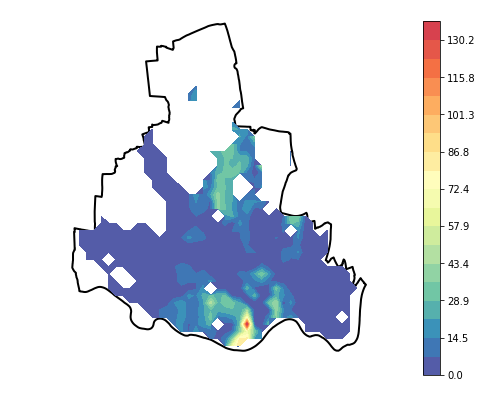

In [22]:
zmesh = mesh_ingestion(sensors, metadata, osm_features, variables, mesh, '2018-07-01 21:00:00')
y_pred = predict(zmesh, mesh, gb)

plotmesh_interpolation_newcastle(y_pred, mesh, newcastle)